## MLP Autoencoder model with random noise

In [6]:
import os
import time
import numpy as np

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

### Load Data

In [8]:
mnist_train = datasets.MNIST(
    root="mnist", 
    train=True, 
    download=True, 
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    root="mnist", 
    train=False, 
    download=True, 
    transform=transforms.ToTensor()
)

### Split Train/Valid Datasets

In [9]:
random_seed = 0
torch.manual_seed(random_seed)

# Train:Valid = 9:1
val_size = int(len(mnist_train) * 0.1)
train_size = len(mnist_train) - val_size

mnist_train, mnist_valid = random_split(mnist_train, [train_size, val_size])
print(len(mnist_train), len(mnist_valid))

54000 6000


In [16]:
mnist_dataset = [mnist_train, mnist_valid, mnist_test]

mnist_train_loader = DataLoader(dataset=mnist_train, batch_size=64, shuffle=True, drop_last=True)
mnist_valid_loader = DataLoader(dataset=mnist_valid, batch_size=64, shuffle=False, drop_last=True)   
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=64, shuffle=False, drop_last=True)

In [10]:
# Add random noises.
def add_noise(data, mean=0., std=0.1):
    """
    A function to apply the Gaussian noise to data.
    data: Tensor 
    mean: Average value of noises
    std: Standard deviation of noises
    """
    random_noise = torch.randn(data.size()) * std + mean
    return data + random_noise

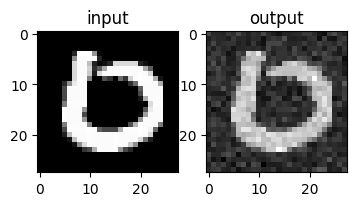

In [11]:
# Chech the data with noise.
sample_x = mnist_valid[0][0].unsqueeze(dim=0)\

fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 2, 1)
ax.imshow(sample_x.squeeze(), cmap='gray')
ax.title.set_text("input")

ax = fig.add_subplot(1, 2, 2)
ax.imshow(add_noise(sample_x, std=0.1).squeeze(), cmap='gray')
ax.title.set_text("output")

### Train the model

In [12]:
class MLP_Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 28 * 28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        latent_x = self.encoder(x)
        y = self.decoder(latent_x)
        y = y.view(-1,1, 28, 28)
        return y

In [13]:
class Noisy_Autoencoder_Trainer(nn.Module):
    def __init__(self, model, dataset, opt="adam", lr=0.001, 
                 has_scheduler=False, device="cpu", noise_mean=0., noise_std=0.1):
        """
        Args:
        model: A classification model that you want to use
        n_class: Number of class 
        opt: Optimizer
        lr: Learning rate
        has_scheduler: True if you want to use the learning rate scheduler
        device: Device that you are using for the training(cpu/cuda).
        noise_mean: Average value of noises
        noise_std: Standard deviation of noises
        """
        super().__init__()

        self.model = model                            
        self.loss = nn.MSELoss()

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler 
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device
        self.train_data = dataset[0]
        self.valid_data = dataset[1]
        self.test_data = dataset[2]
        
        self.noise_mean = noise_mean
        self.noise_std = noise_std

    def _get_optimizer(self, opt, lr=0.001):
        """
        Args:
        opt: Optimizer
        lr: Learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
        # self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5, visualize=False):
        """
        A function to train networks.
        Args:
        train_loader: Train dataset loader
        valid_loader: Validation dataset loader
        max_epochs: Number of epochs
        disp_epochs: Number of epoch frequency to display training logs
        visualize: True if you want to plot the image of the result 
        """
        print("===== Train Starts. =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": []}
        for e in range(max_epochs):
            train_loss = self._train_epoch(train_loader)
            valid_loss = self._valid_epoch(valid_loader)

            history["train_loss"].append(train_loss)
            history["valid_loss"].append(valid_loss)

            if self.has_scheduler:
                self.scheduler.step()

            if e % disp_epoch == 0: 
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, time: {time.time()-start_time:>3f}")
                if visualize: 
                    self.vis_train_val() 
                start_time = time.time()   

        self.plot_history(history)

    def _train_epoch(self, train_loader):
        """
        A function that trains the model by each epoch
        Args:
        train_loader: Train dataset loader
        Returns: Average loss and accuracy
        """
        epoch_loss = 0
        self.model.train()
        for (x, y) in train_loader:
            
            x = x.to(self.device)
            noisy_x = self.add_noise(x, self.device)

            x_hat = self.model(noisy_x) # Restored input X from noisy input by the model 
            loss = self.loss(x_hat, x) # To make training targets without noises

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step() 
            
            epoch_loss += loss.to("cpu").item()    

        epoch_loss /= len(train_loader)  

        return epoch_loss
  
    def _valid_epoch(self, valid_loader):
        """
        A function that evaluate the current model with validation dataset.
        Args:
        valid_loader: Validation dataset loader
        Returns: Average loss and accuracy
        """
        epoch_loss = 0
        self.model.eval()
        with torch.no_grad():
            for (x, y) in valid_loader:
                x = x.to(self.device)
                noisy_x = self.add_noise(x, self.device)

                x_hat = self.model(noisy_x)
                loss = self.loss(x_hat, x)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(valid_loader)

        return epoch_loss

    def plot_history(self, history):
        """
        A  function that plots the history of the model.
        Args:
        history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
        """
        fig = plt.figure(figsize=(10, 10))

        plt.plot(history["train_loss"], color="red", label="train loss")
        plt.plot(history["valid_loss"], color="blue", label="valid loss")
        plt.title("Loss")
        plt.legend()

        fig.show()

    def test(self, test_loader):
        """
        A function to evaluate the model with test dataset.
        Args:
        test_loader: Test dataset loader
        Returns: Average loss and accuracy
        """
        print("===== Test Starts. =====")
        start_time = time.time()
        epoch_loss = 0
        self.model.eval()                  # self.model을 eval 모드로 전환 --> nn.Module의 내장함수
        with torch.no_grad():              # model에 loss의 gradient를 계산하지 않음
            for (x, y) in test_loader:
                x = x.to(self.device)
                noisy_x = self.add_noise(x, self.device)

                x_hat = self.model(noisy_x)
                loss = self.loss(x_hat, x)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(test_loader)

        print(f"Test loss: {epoch_loss:>6f}, time: {time.time()-start_time:>3f}")
        self.vis_test()     # 결과 이미지 plot
    
    def vis_train_val(self):
        """
        A function to visualize the training and validation results.
        """
        fig = plt.figure(figsize=(9,6))
        for i in range(4):
            img = self.train_data[i][0]
            ax = fig.add_subplot(4, 6, i*6+1)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_train")
            
            img = self.add_noise(self.train_data[i][0], device="cpu")
            ax = fig.add_subplot(4, 6, i*6+2)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("noisy_x_train")

            img = self.model(self.train_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 6, i*6+3)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_train")

            img = self.valid_data[i][0]
            ax = fig.add_subplot(4, 6, i*6+4)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("y_valid")
                
            img = self.add_noise(self.valid_data[i][0], device="cpu")
            ax = fig.add_subplot(4, 6, i*6+5)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("noisy_x_valid")

            img = self.model(self.valid_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 6, i*6+6)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_valid")
        
    def vis_test(self):
        """
        A function to visualize the test result.
        """
        fig = plt.figure(figsize=(9,6))
        for i in range(4):
            img = self.test_data[i][0]
            ax = fig.add_subplot(4, 3, i*3+1)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_test")
                
            img = self.add_noise(self.test_data[i][0], device="cpu")
            ax = fig.add_subplot(4, 3, i*3+2)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("noisy_x_test")

            img = self.model(self.test_data[i][0].unsqueeze(dim=0).to(device)).to("cpu").detach()
            ax = fig.add_subplot(4, 3, i*3+3)
            ax.imshow(img.squeeze(),cmap='gray')
            if i == 0:
                ax.set_title("x_hat_test")
        
    def add_noise(self, data, device):
        """
        A function to apply the Gaussian noise to data.
        data: Tensor 
        mean: Average value of noises
        std: Standard deviation of noises
        """
        random_noise = torch.randn(data.size()).to(device) * self.noise_std + self.noise_mean
        return data + random_noise

===== Train Starts. =====
Epoch: 0, train loss: 0.055113, valid loss: 0.040429, time: 14.696846
Epoch: 1, train loss: 0.037984, valid loss: 0.036243, time: 14.696716
Epoch: 2, train loss: 0.035244, valid loss: 0.034645, time: 18.759856
Epoch: 3, train loss: 0.033785, valid loss: 0.033391, time: 15.213338
Epoch: 4, train loss: 0.032900, valid loss: 0.032506, time: 17.129220
Epoch: 5, train loss: 0.032136, valid loss: 0.031953, time: 15.642198
Epoch: 6, train loss: 0.031592, valid loss: 0.031586, time: 16.155815
Epoch: 7, train loss: 0.031240, valid loss: 0.031246, time: 14.681762
Epoch: 8, train loss: 0.030960, valid loss: 0.030805, time: 17.049425
Epoch: 9, train loss: 0.030694, valid loss: 0.030387, time: 15.713012


C:\Users\yulimy\AppData\Local\Temp\ipykernel_12616\3565860401.py:144: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


Training time : 167.700894
===== Test Starts. =====
Test loss: 0.030122, time: 1.791213


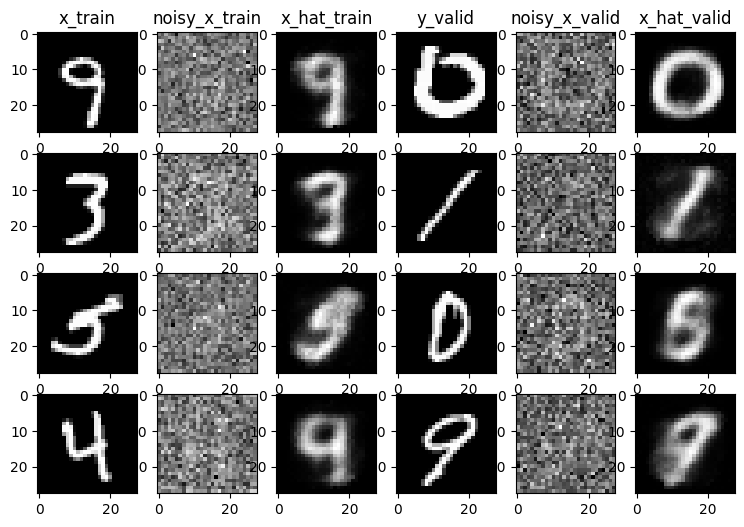

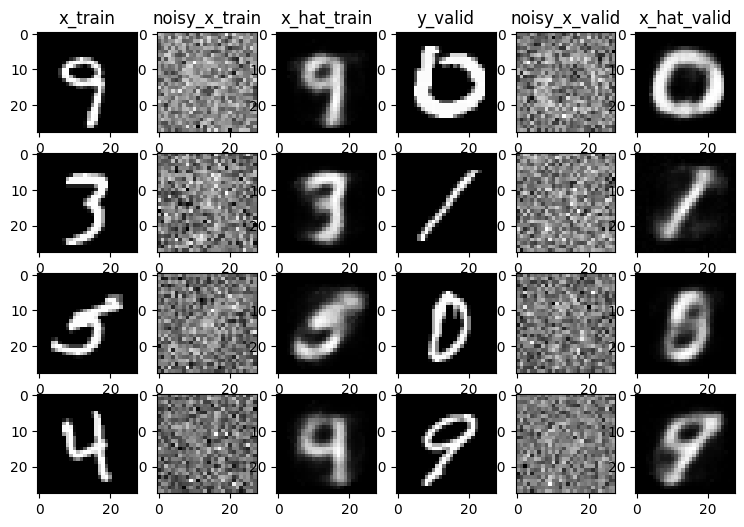

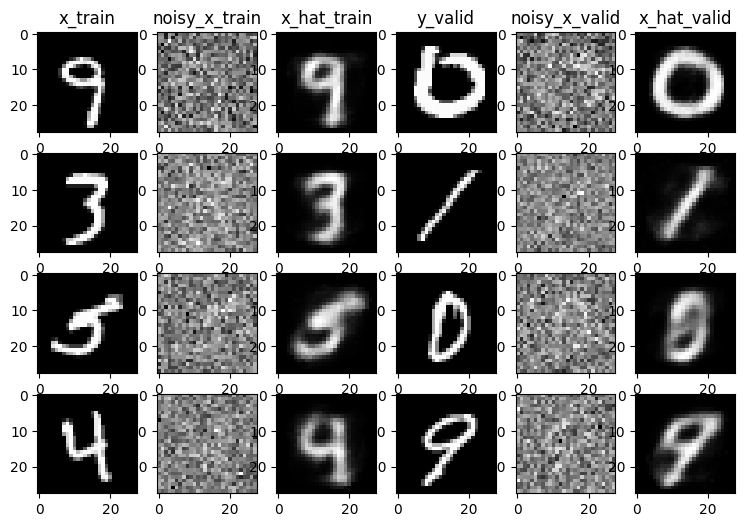

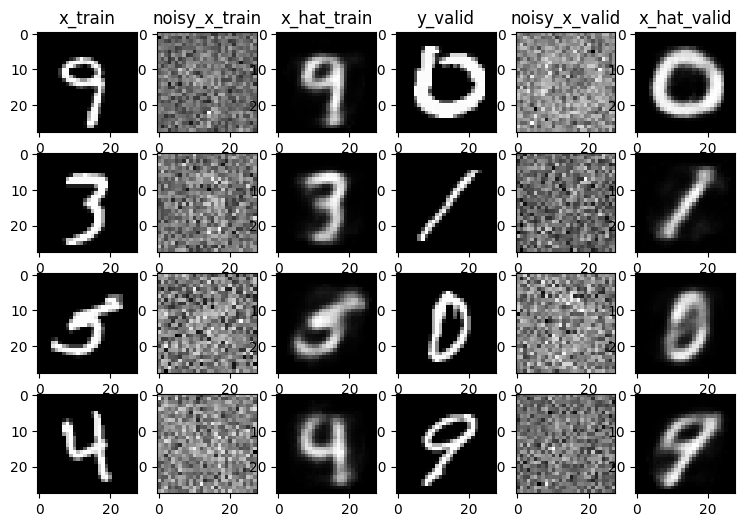

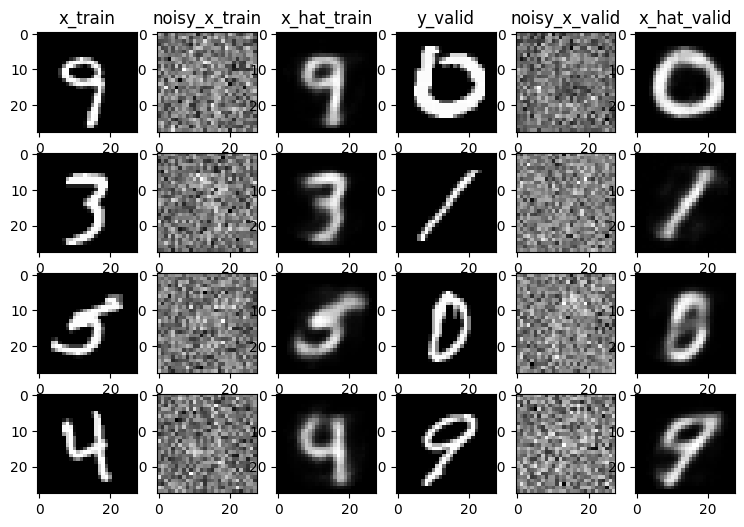

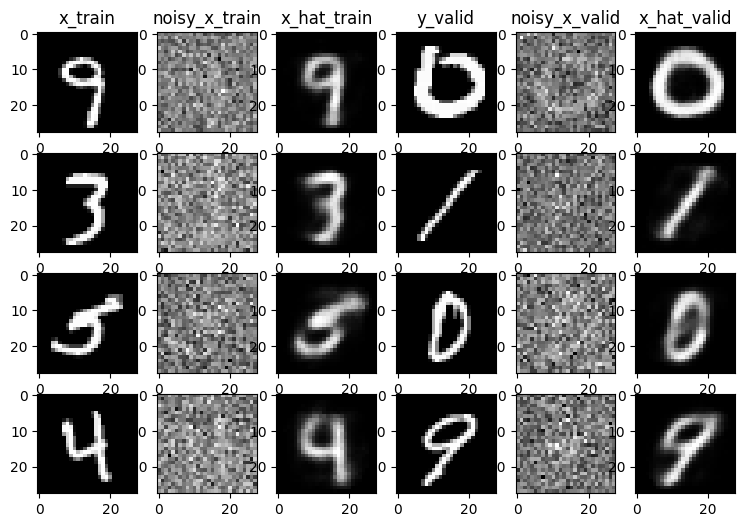

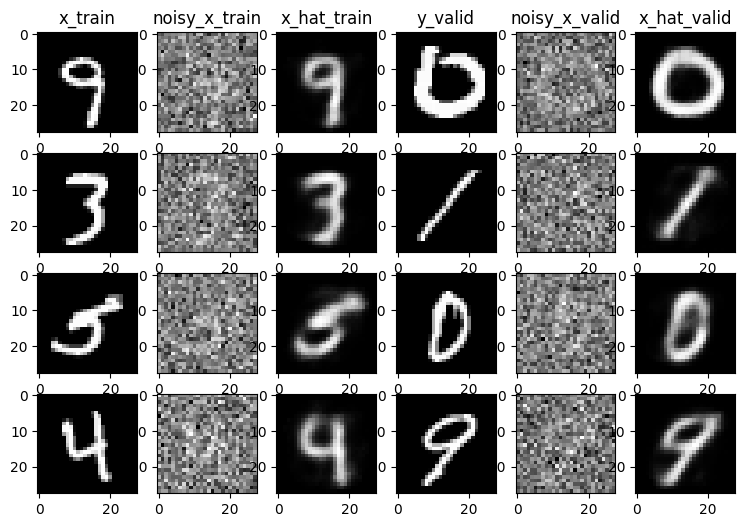

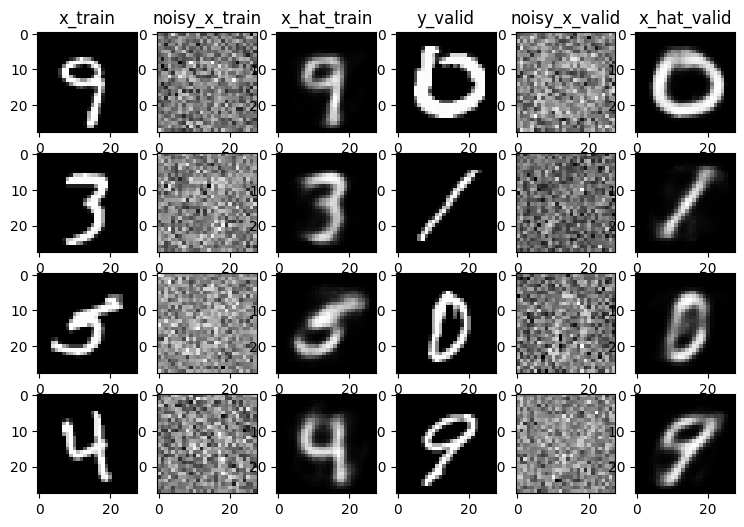

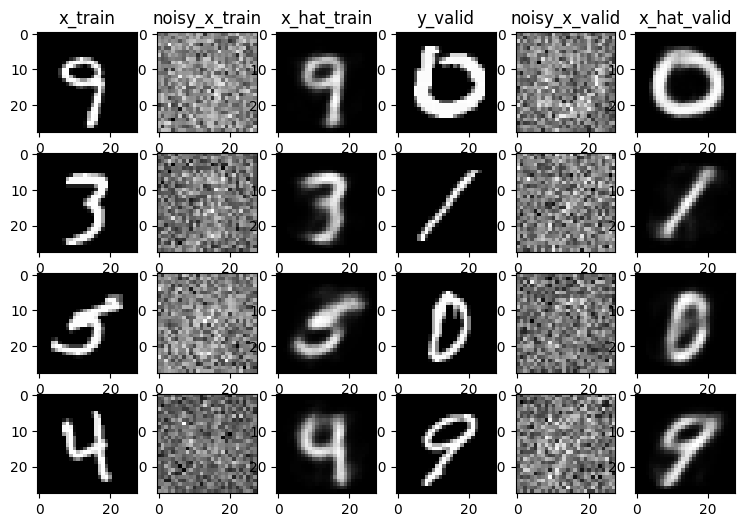

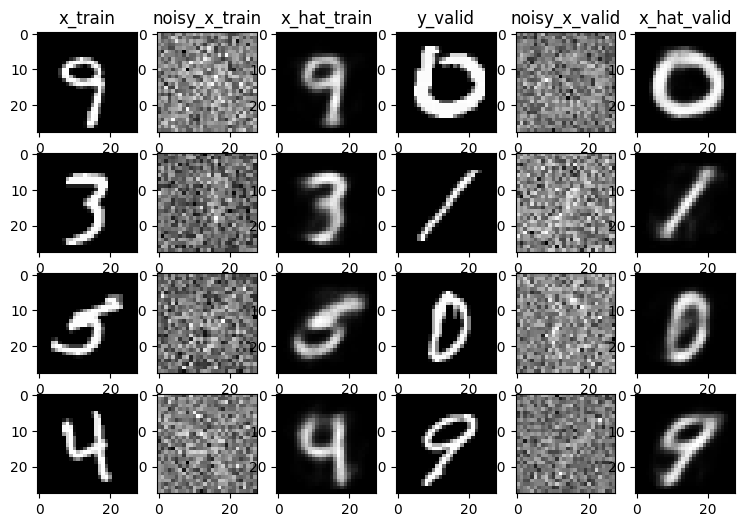

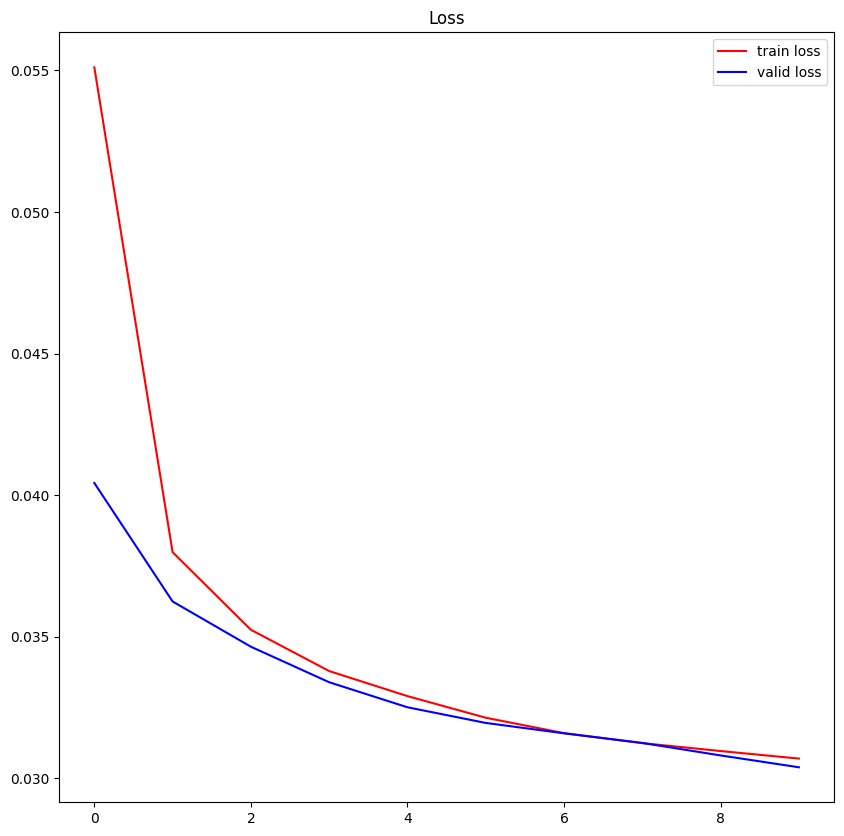

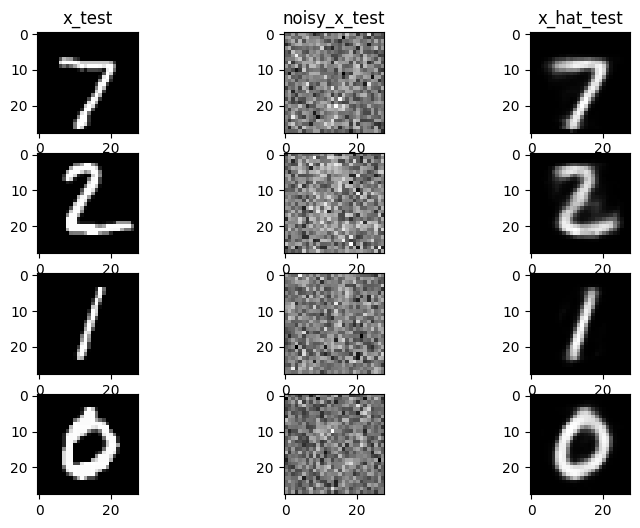

In [17]:
noisy_mlp_ae = MLP_Autoencoder()                              
trainer = Noisy_Autoencoder_Trainer(model=noisy_mlp_ae,
                                    dataset=mnist_dataset,
                                    opt="adam", 
                                    lr=0.001, 
                                    has_scheduler=False, 
                                    device=device, 
                                    noise_std=1.0).to(device)

start_time = time.time()

trainer.train(mnist_train_loader, 
              mnist_valid_loader,
              max_epochs=10, 
              disp_epoch=1, 
              visualize=True)

print(f"Training time : {time.time()-start_time:>3f}")
trainer.test(mnist_test_loader)